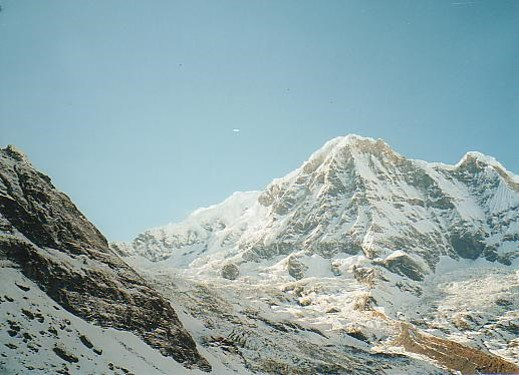

In [12]:
import cv2 as cv
from google.colab.patches import cv2_imshow
from urllib.request import urlopen 
import numpy as np

req_left = urlopen('https://dbloisi.github.io/corsi/images/montagna-1.jpg')
arr_left = np.array(bytearray(req_left.read()), dtype=np.uint8)
img_left = cv.imdecode(arr_left, -1)
cv2_imshow(img_left)

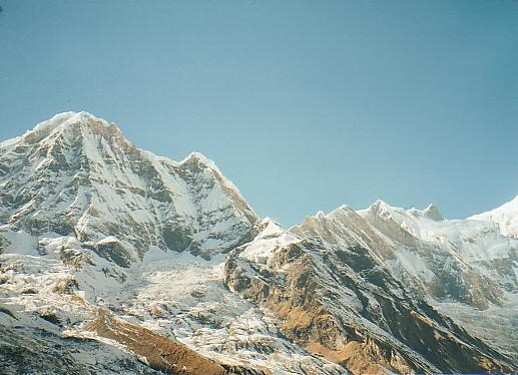

In [13]:
req_right = urlopen('https://dbloisi.github.io/corsi/images/montagna-2.jpg')
arr_right = np.array(bytearray(req_right.read()), dtype=np.uint8)
img_right = cv.imdecode(arr_right, -1)
cv2_imshow(img_right)

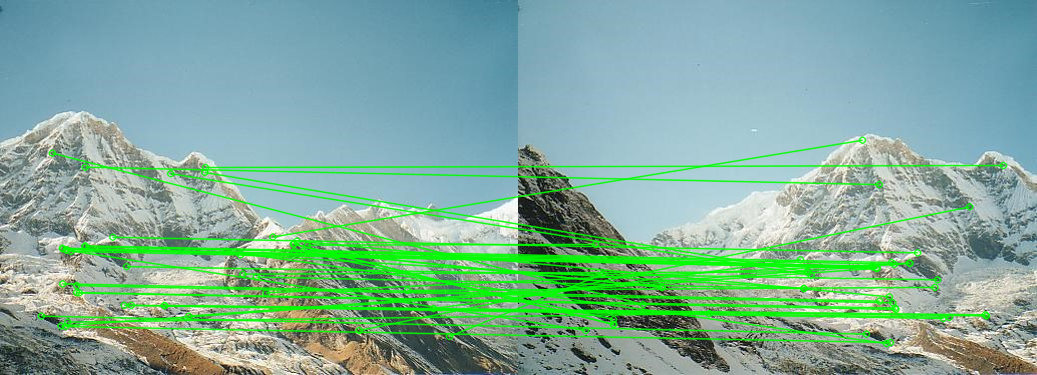

In [14]:
# orb descriptor
orb = cv.ORB_create()
# find key points
kp1, des1 = orb.detectAndCompute(img_right, None)
kp2, des2 = orb.detectAndCompute(img_left, None)
# brute force matching
match = cv.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)
# distance ratio
# "Distinctive Image Features from Scale-Invariant Keypoints"
# by David G. Lowe
good = []
for m,n in matches:
    if m.distance < 0.85*n.distance:
        good.append(m)

# drawing good matches
draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)
matches_img = cv.drawMatches(img_right,kp1,img_left,kp2,good,None,**draw_params)
cv2_imshow(matches_img)

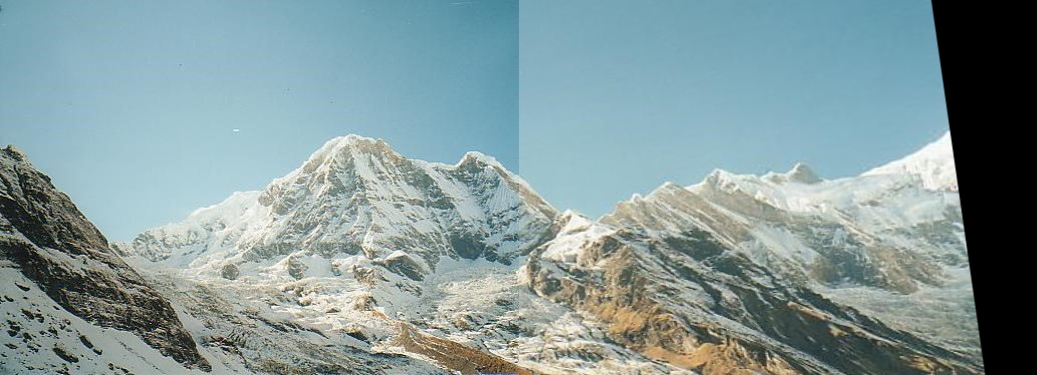

In [16]:
# homography computation
MIN_MATCH_COUNT = 5
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    h,w,c = img_right.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts, M)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

# creating panorama image
panorama_img = cv.warpPerspective(img_right,M,(img_left.shape[1] + img_right.shape[1], img_left.shape[0]))
panorama_img[0:img_left.shape[0],0:img_left.shape[1]] = img_left
cv2_imshow(panorama_img)